In [117]:
from skimage import measure
import rasterio
import numpy as np
import geopandas as gpd

# Set the input and output file names
input_file = '/Users/aakash/Desktop/MTP2/codev2/data/temp/file.tif'
input_file1 = '/Users/aakash/Desktop/MTP2/exp/elevation/iit_mandi1.tif'
output_file = '/Users/aakash/Desktop/MTP2/codev2/data/temp/file.shp'

    


0.02897356799739078
0.06573218112536694


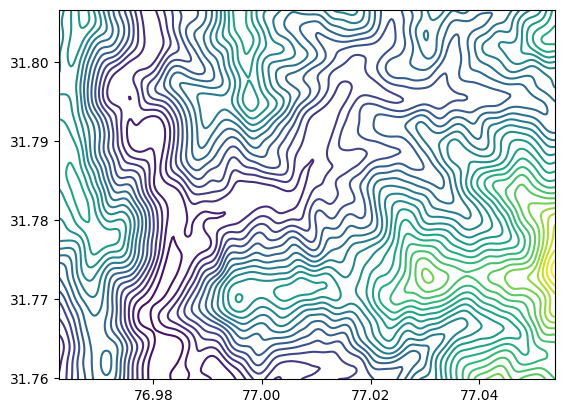

In [138]:
from skimage import measure, filters
import rasterio
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

# Set the input and output file names


# Open the DEM file using rasterio
with rasterio.open(input_file1) as src:
    # Read the raster data
    dem = src.read(1)
    # print(dem)

    # Set the contour interval
    interval = 0.0015

    # Smooth the DEM using a Gaussian filter
    dem_smooth = filters.gaussian(dem, sigma=3)

    min_v = dem_smooth.min()
    max_v = dem_smooth.max()
    print(min_v)
    print(max_v)
    
    # Get the coordinates of the top-left corner of the DEM
    x_min = src.bounds.left
    y_max = src.bounds.top
    
    # generate contour lines
    contours = plt.contour(dem_smooth, levels=np.arange(min_v, max_v, interval), origin='image', extent=[x_min, x_min + src.res[0] * src.width, y_max - src.res[1] * src.height, y_max])
    # print(contours.allsegs)

    # show the plot
    plt.show()


In [139]:
import os
import numpy as np
from scipy.ndimage import gaussian_filter
from scipy.ndimage import median_filter
from osgeo import gdal, ogr


# Open the DEM file using GDAL
dem_ds = gdal.Open(input_file1)

# Get the raster band
dem_band = dem_ds.GetRasterBand(1)

# Read the raster data into a NumPy array
dem = dem_band.ReadAsArray()

# Smooth out the raster data using a Gaussian filter
sigma = 50 # Adjust the sigma value to control the level of smoothing
smooth_dem = gaussian_filter(dem, sigma)
# dem_smoothed = median_filter(smooth_dem, size=5)

# Create a new vector layer to hold the contour lines
contour_shp = ogr.GetDriverByName('ESRI Shapefile').CreateDataSource(output_file)
contour_lyr = contour_shp.CreateLayer('contour_lines', dem_ds.GetSpatialRef(), ogr.wkbLineString)

# Set the contour interval
interval = 200

# Generate the contour lines using GDAL
gdal.ContourGenerate(dem_band, interval, 0, [], 0, 0, contour_lyr, 0, 1)

# Close the data sources
dem_ds = None
contour_shp = None


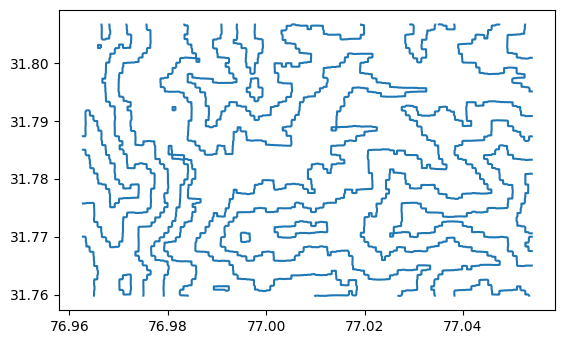

In [140]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Set the path to the output shapefile
contour_shp = output_file

# Read the contour lines from the shapefile using GeoPandas
contours = gpd.read_file(contour_shp)
# print(contours)

# Plot the contour lines using matplotlib
fig, ax = plt.subplots()
contours.plot(ax=ax)
plt.show()


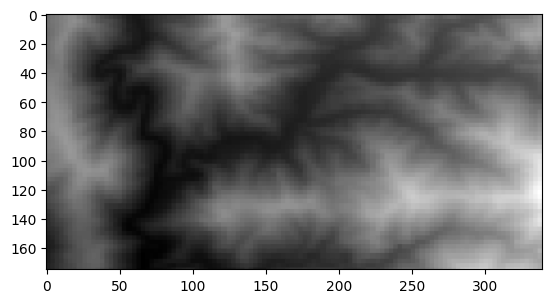

In [141]:
import matplotlib.pyplot as plt
import rasterio
with rasterio.open(input_file1) as src:
    dem_band = src.read(1)
plt.imshow(dem_band,cmap='gray')
plt.show()

In [142]:
import rasterio
from scipy.signal import find_peaks

# Load the DEM file
with rasterio.open(input_file1) as src:
    dem = src.read(1)

# Find the highest peak in the DEM
peaks, _ = find_peaks(dem.ravel(), distance=20)
highest_peak = peaks[dem.ravel()[peaks].argmax()]

# Traverse the DEM to find the saddle
row, col = np.unravel_index(highest_peak, dem.shape)
while True:
    # Get the elevation values of the surrounding pixels
    elev = dem[max(0, row-1):min(row+2, dem.shape[0]), 
               max(0, col-1):min(col+2, dem.shape[1])]
    # Find the lowest elevation value
    min_elev = elev.min()
    # Check if the current pixel is the saddle
    if dem[row, col] == min_elev:
        saddle = row * dem.shape[1] + col
        break
    # Move to the pixel with the lowest elevation value
    row_offset, col_offset = np.unravel_index(elev.argmin(), elev.shape)
    row += row_offset - 1
    col += col_offset - 1

# Calculate the prominence of the peak
prominence = dem.ravel()[highest_peak] - dem.ravel()[saddle]
print(f"Prominence of the highest peak: {prominence:.2f} meters")


Prominence of the highest peak: 64.00 meters


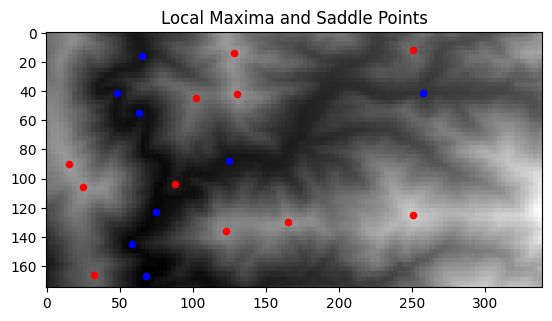

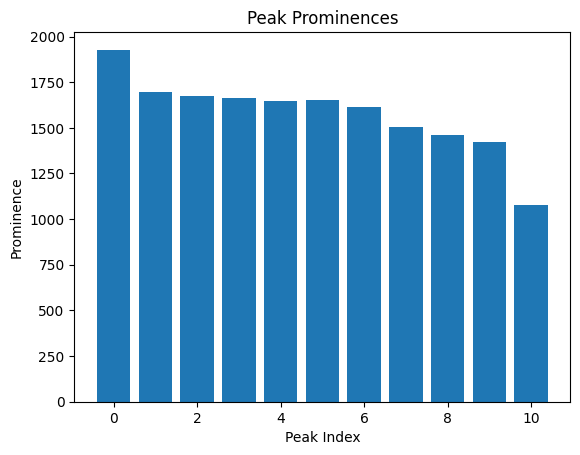

In [143]:
from skimage.feature import peak_local_max
import rasterio
import numpy as np
import matplotlib.pyplot as plt


# Open the DEM file using rasterio
with rasterio.open(input_file1) as src:
    # Read the raster data
    dem = src.read(1)

    # Smooth the DEM using a Gaussian filter
    dem_smooth = filters.gaussian(dem, sigma=3)

    # Find the local maxima in the smoothed DEM
    local_maxima = peak_local_max(dem_smooth, min_distance=5)

    # Find the saddle points in the smoothed DEM
    saddle_points = peak_local_max(-dem_smooth, min_distance=5)

    # Find the prominence of each peak
    prominences = []
    for peak in local_maxima:
        prominence = dem[peak[0], peak[1]] - np.max(dem_smooth[peak[0]-10:peak[0]+10, peak[1]-10:peak[1]+10])
        prominences.append(prominence)

    # Plot the DEM, local maxima, and saddle points
    fig, ax = plt.subplots()
    ax.imshow(dem, cmap='gray')
    ax.scatter(local_maxima[:, 1], local_maxima[:, 0], marker='o', s=20, c='r')
    ax.scatter(saddle_points[:, 1], saddle_points[:, 0], marker='o', s=20, c='b')
    ax.set_title('Local Maxima and Saddle Points')

    # Plot the prominences
    fig, ax = plt.subplots()
    ax.bar(range(len(prominences)), prominences)
    ax.set_xlabel('Peak Index')
    ax.set_ylabel('Prominence')
    ax.set_title('Peak Prominences')

    # Show the plots
    plt.show()
